# WEEK5_GAN_Project


Generative Adversarial Networks (GANs) are a powerful class of neural networks that are used for unsupervised learning. It was developed and introduced by Ian J. Goodfellow in 2014. GANs are basically made up of a system of two competing neural network models which compete with each other and are able to analyze, capture and copy the variations within a dataset. 

A GAN consists of at least two neural networks: 
1. Generator model 
2. Discriminator model. 
The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. Overall, there are 300 Monet paintings in the dataset, and 7038 photos which are used to discriminate with our GAN network. This generator is trained using a discriminator.The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.
Lets build a training model cycleGAN , in which 10,000 style monet-images as results.

In [1]:
#utilities
import numpy as np
import random
import re
import pandas as pd
import PIL
import os
import shutil


#plots
import matplotlib.pyplot as plt
# modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Prints the current working directory
os.getcwd()
#changing my working directory as per project folder gan files.
%cd "/Users/kavithasundaram/Documents/SKavitha/spring march-may 2023/DTSA-5511/week5/gan-getting-started"
tf.__version__


/Users/kavithasundaram/Documents/SKavitha/spring march-may 2023/DTSA-5511/week5/gan-getting-started


/Users/kavithasundaram/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


'2.12.0'

In [2]:
#list of datafiles from kaggle dataset
os.listdir("./")



['images.zip',
 'photo_jpg',
 'monet_jpg',
 'photo_tfrec',
 'monet_tfrec',
 'submit_images.jpg']

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [4]:
monet_tfrec = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
photo_tfrec = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))
monet_jpg = './monet_jpg/'
photo_jpg = './photo_jpg/'
print(f'Monet TFRecord files: {len(monet_tfrec)}')
print(f'photo TFRecord files: {len(photo_tfrec)}')
print(f"There is {len(os.listdir(monet_jpg))} gan_monet")
print(f"There is {len(os.listdir(photo_jpg))} gan photo")    

Monet TFRecord files: 5
photo TFRecord files: 20
There is 300 gan_monet
There is 7038 gan photo


| **Monet**                                   | **Photo** | 
|-------------------------------------------- |---------|
| It has 2 categories(jpg,tfrec)              | It has 2 categories(jpg,tfrec)| 
| monet_jpg = 300                             | photo_jpg = 7038  | 
| monet tfrecord files = 5                    | photo tfrecord files = 20  | 


#citation:https://keras.io/examples/keras_recipes/tfrecord/

The images have to be converted to tensors so that it will be a valid input in our model. As images utilize an RBG scale, we specify 3 channels.
We also reshape our data so that all of the images will be the same shape.
As we load in our data, we need both our monet paintings and our photo images. 

In [5]:
IMAGE_SIZE = [256, 256]
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


### Visualize imput images:

Metal device set to: Apple M1 Pro


2023-04-20 12:39:58.661181: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


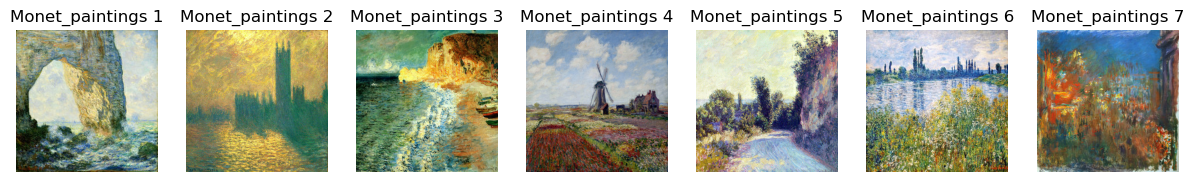

In [6]:

monet_dis = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_dis = load_dataset(photo_tfrec, labeled=True).batch(1)
monet_gan = next(iter(monet_dis))
photo_gan = next(iter(photo_dis))

def display_samples(ds, title, samples=7):
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_samples(monet_dis, 'Monet_paintings')

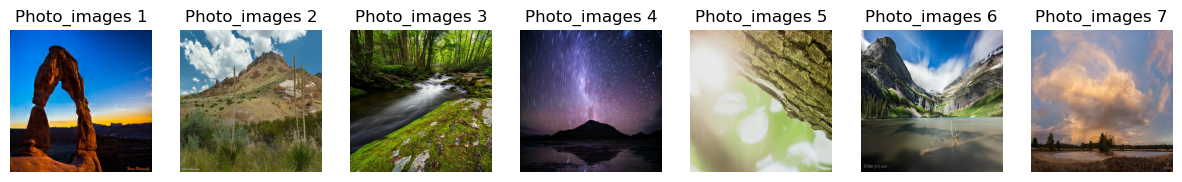

In [7]:
display_samples(photo_dis, 'Photo_images')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


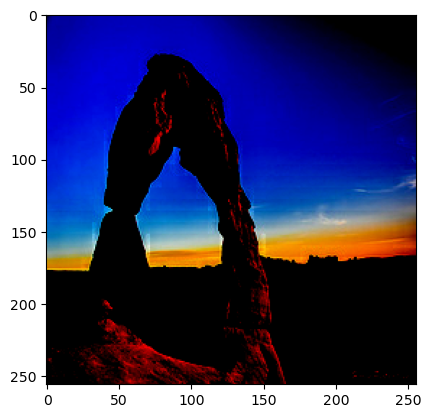

In [8]:
plt.imshow(photo_gan[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


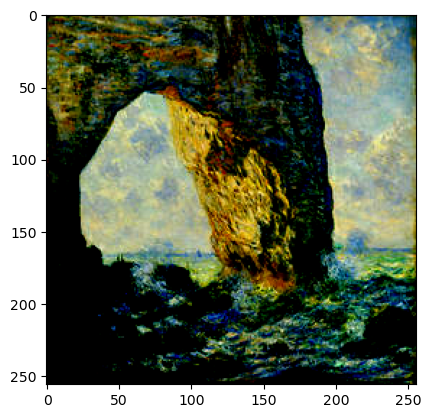

In [9]:
plt.imshow(monet_gan[0])
plt.show()

Lets use deep learning to apply the Monet-esque formatting from his paintings to the currently unformatted photos.

## 1. Model Architecture :  

#citation:https://www.kaggle.com/code/songseungwon/cyclegan-tutorial-from-scratch-monet-to-photo
We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our downsample and upsample methods.

The downsample, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

#### Downsample:

In [10]:
OUTPUT_CHANNELS = 3


def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

#### Upsample:

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#### Generator:

In [12]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Build the Discriminator: 
The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [13]:
def Discriminator():
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
with strategy.scope():
    monet_g = Generator() # transforms photos to Monet-esque paintings
    photo_g = Generator() # transforms Monet paintings to be more like photos

    monet_d = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_d = Discriminator() # differentiates real photos and generated photos

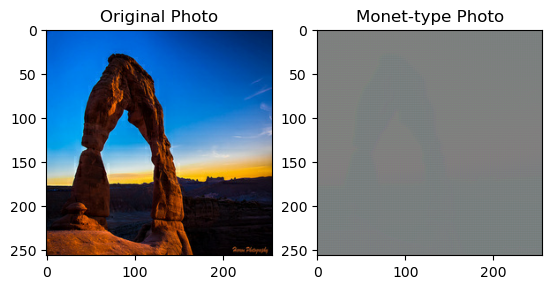

In [15]:
to_monet = monet_g(photo_gan)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(photo_gan[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-type Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## CycleGAN:

CycleGAN would be a way to translate photos into Monets, as we're turning one picture into another picture, but trying to stylize them in some particular way.

In [16]:
class CycleGan(keras.Model):
    def __init__(self,monet_g,photo_g,monet_d,photo_d,lambda_cycle=10,):
        super(CycleGan, self).__init__()
        self.m_gen = monet_g
        self.p_gen = photo_g
        self.m_dis = monet_d
        self.p_dis = photo_d
        self.lambda_cycle = lambda_cycle
        
    def compile(self,m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_dis(real_monet, training=True)
            disc_real_photo = self.p_dis(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_dis(fake_monet, training=True)
            disc_fake_photo = self.p_dis(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_dis.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_dis.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_dis.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_dis.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Training cycleGAN model:

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [18]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [19]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_g, photo_g, monet_d, photo_d
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [20]:
history_gan= cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dis, photo_dis)),
    epochs=3
)

Epoch 1/3
300/300 [==============================] - 150s 409ms/step - monet_gen_loss: 5.0511 - photo_gen_loss: 5.1780 - monet_disc_loss: 0.6456 - photo_disc_loss: 0.6318
Epoch 2/3
300/300 [==============================] - 119s 397ms/step - monet_gen_loss: 3.5869 - photo_gen_loss: 3.6752 - monet_disc_loss: 0.6480 - photo_disc_loss: 0.6260
Epoch 3/3
300/300 [==============================] - 119s 398ms/step - monet_gen_loss: 3.5594 - photo_gen_loss: 3.6699 - monet_disc_loss: 0.6457 - photo_disc_loss: 0.6133


### Prediction and analysis:

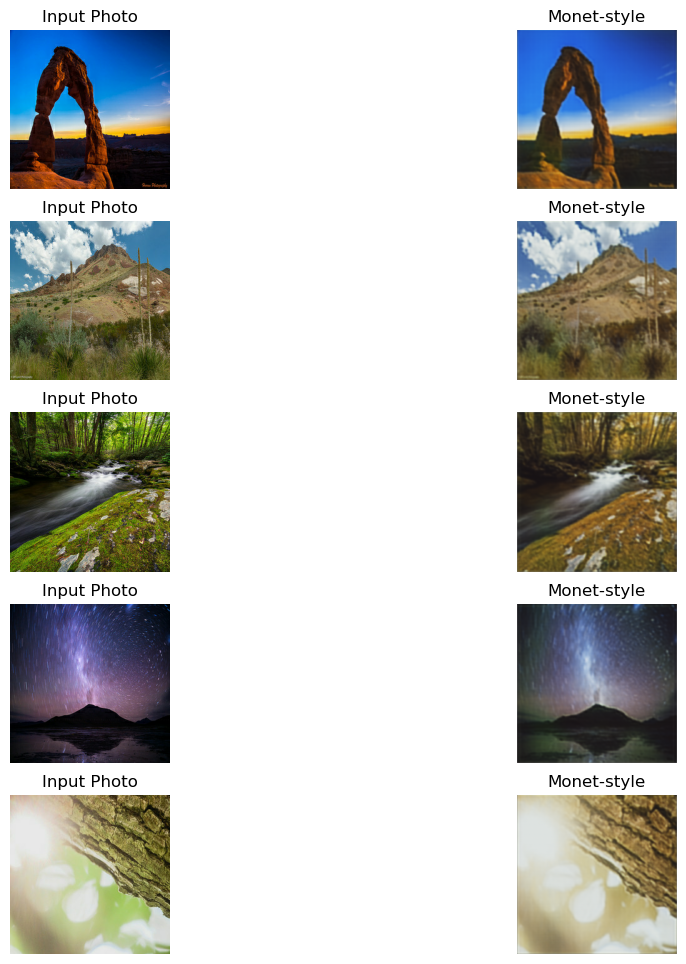

In [21]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dis.take(5)):
    prediction = monet_g(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## CONCLUSION:


There are many ways to fine tune the model, we can keep changing the architecture of the model to see if 
it can get a better result, but it is really time consuming.As you can see clearly, monet paintings looks like same as 
image photos.Process of creating GAN models with other architecture is possible and hyperparametr tuning is time consuming especially for small kaggle projects. We can further focus on fine tuning downsampling, to get effective generator and discriminator. optimizing a lot would be better with adams training with network cycle.
Kaggle dataset refrence was helpfull in completing this mini project with the help of kaggle monet from scratch tutorials as references.

## Submission:

In [ ]:
i = 1
for img in photo_dis.take(-1): # -1 returns all the samples in the dataset
    prediction = monet_g(img)
    prediction = prediction * 0.5 + 0.5
    im = tf.keras.utils.array_to_img(prediction[0], data_format=None, scale=True, dtype=None)
    # im.show()
    im.save(f'./submit_images.jpg')
    plt.close()
    i += 1


In [ ]:
shutil.make_archive("./images", 'zip', "./submit_images")

### GITHUB REPOSITORY URL

https://github.com/kavishant87/WEEK5-GAN-PROJECT